In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import sys
import numpy as np
import cmocean.cm as ocm

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')
int_dir = os.path.join(proj_dir,'data','analysis','interim')
src_dir = os.path.join(proj_dir,'src')
fig_dir = os.path.join(proj_dir,'reports','shallow_melting','figures')

sys.path.append(src_dir)
%load_ext autoreload
%autoreload 1

tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)

from log_progress import log_progress
from calc_z import calc_z
from make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves
from visualization.shiftedColorMap import shiftedColorMap

In [2]:
grd_path = os.path.join(data_dir,'interim','grd2_dV.nc')
grd = xr.open_dataset(grd_path)

temp_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_temp_DJFavg.nc')
zeta_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_zeta_DJFavg.nc')
temp_s = xr.open_dataset(temp_path).temp.squeeze()
zeta_s = xr.open_dataset(zeta_path).zeta.squeeze()

temp_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_temp_JJAavg.nc')
zeta_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_zeta_JJAavg.nc')
temp_w = xr.open_dataset(temp_path).temp.squeeze()
zeta_w = xr.open_dataset(zeta_path).zeta.squeeze()

temp_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_temp_avg.nc')
zeta_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_zeta_avg.nc')
temp = xr.open_dataset(temp_path).temp.squeeze()
zeta = xr.open_dataset(zeta_path).zeta.squeeze()

In [3]:
mask_sector = make_mask_sector(grd)
mask_shelf = make_mask_shelf_sector(grd,mask_sector,1500) 
mask_shelf['Total Antarctica'][:,3000:]=False
mask_shelf['Total Antarctica'][2500:,:]=False
grd.mask_rho[1000:1500,2000:2500] = False

# subsurface temperature maximum depth

In [4]:
def assign_depth(ds,zeta):
    h = grd.h.values
    zice = grd.zice.values
    theta_s = 7
    theta_b = 8
    hc = 250
    N = 31
    zeta = zeta.values
    Vstretching = 4

    depths,s,C = calc_z(h,zice,theta_s,theta_b,hc,N,zeta,Vstretching)

    return ds.assign_coords(depth = xr.DataArray(depths,dims=['s_rho','eta_rho','xi_rho']))

def make_sstm(temp,mask):
    temp_ss = temp.where(mask).copy()
    sstm = temp_ss.depth.where(temp_ss == temp_ss.max('s_rho')).max('s_rho')
    sstm.values[sstm==temp_ss.depth.max('s_rho')]=0
    return sstm

In [5]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:54380 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 101.38 GB


In [5]:
temp_s = assign_depth(temp_s,zeta_s)
temp_w = assign_depth(temp_w,zeta_w)
temp = assign_depth(temp,zeta)

In [92]:
mask = (mask_shelf['Total Antarctica'] == 1) & (grd.zice == 0)
chunks = {'eta_rho':400,'xi_rho':400}

sstm_s = make_sstm(temp_s.chunk(chunks),(mask == 1) & (temp_s.depth <= -50)).load()
sstm_w = make_sstm(temp_w.chunk(chunks),(mask == 1) & (temp_w.depth <= -50)).load()
sstm = make_sstm(temp.chunk(chunks),(mask == 1) & (temp.depth <= -50)).load()

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/da

In [95]:
def reset_surf(sstm,temp):
    sstm.values[sstm==temp.depth.where(temp.depth<=-50).max('s_rho')]=0
    return sstm

sstm = reset_surf(sstm,temp)
sstm_w = reset_surf(sstm_w,temp_w)
sstm_s = reset_surf(sstm_s,temp_s)

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [117]:
%matplotlib inline
import matplotlib

def make_ax(ax,sstm):
    #levs = [0,50,100,200,300,400,500,3000]
    levs = [50,200,400,3000]
    cmap_deep = ocm.deep
    
    cmap = matplotlib.colors.ListedColormap(['gray','white'])  
    ax.pcolormesh(grd.mask_rho,cmap=cmap)
    
    img = ax.contourf(-sstm,levels=levs,cmap=cmap_deep)
    ax.contourf(sstm.where(sstm==0),colors=['yellow'])
    #ax.pcolormesh(-sstm,vmin=50,vmax=500,cmap=ocm.deep)
    ax.contour(-sstm,levels=levs,colors=('k'),linewidths=0.25,corner_mask=True)
    
    z = grd.zice.where((grd.mask_rho ==1) & (grd.zice<0))
    ax.contourf(-z,cmap=cmap_deep,levels=levs)
    ax.contour(-z,levels=levs,colors='k',linewidths=0.25,corner_mask=True)
    
    
    ice_mask = (grd.zice < 0) & (grd.mask_rho ==1)
    ax.contour(ice_mask, levels=['0.1'], colors=('k'),linewidths=0.5)

    
    return img,ax

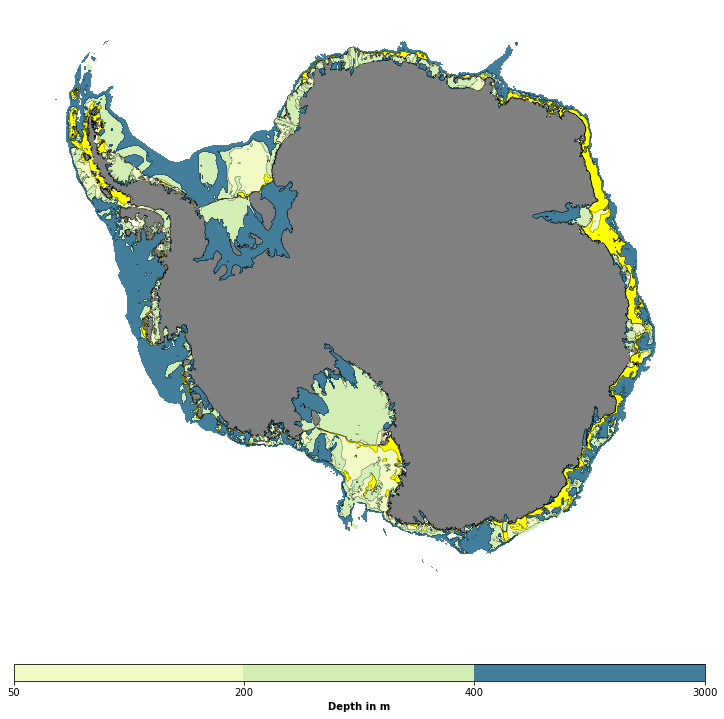

In [118]:
plt.close()

fig,ax = plt.subplots(figsize=(12,12))

img,ax = make_ax(ax,sstm_s)
ax.axis('off')

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

cbar = plt.colorbar(img, cax=cbar_ax, orientation="horizontal", pad=0.1)
cbar.set_label(label='Depth in m',weight='bold')
plt.show()

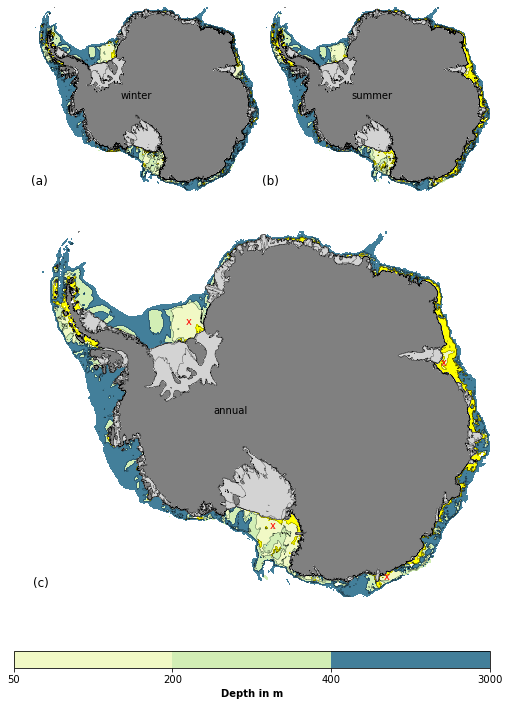

In [119]:
import string
%matplotlib inline

fig = plt.figure(figsize=(8.27,12))
gs = fig.add_gridspec(ncols=2,nrows=3)

#fig,axes = plt.subplots(ncols=3,figsize = (8.27, 3))

#ax1,ax2,ax3 = axes.flatten()
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1:,:])

img,ax1 = make_ax(ax1,sstm_w)
img,ax2 = make_ax(ax2,sstm_s)
img,ax3 = make_ax(ax3,sstm)

for ax in [ax1,ax2,ax3]:
    ax.contourf(grd.mask_rho.where((grd.mask_rho==1) & (grd.zice<0)),colors='lightgray')

for loc in coords:
    ax3.annotate('x',(loc['xi'], loc['eta']), xycoords='data',color='r')

n=0
for ax in [ax1,ax2,ax3]:
    ax.set_ylim((176,2493))
    ax.set_xlim((9,2919))
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('')
    #ax.set_xlabel('Salinity (psu)')    
    ax.text(0.01, 0.03, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=12)
    n+=1    
    
ax1.text(0.4, 0.5, "winter", transform=ax1.transAxes)
ax2.text(0.4, 0.5, "summer", transform=ax2.transAxes)
ax3.text(0.4, 0.5, "annual", transform=ax3.transAxes)

fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

cbar = plt.colorbar(img, cax=cbar_ax, orientation="horizontal", pad=0.01)
cbar.set_label(label='Depth in m',weight='bold')

plt.subplots_adjust(wspace=0.001,hspace=0.001)

out_path = os.path.join(fig_dir,'SSTM_zice_all.png')
fig.savefig(out_path,format='png',dpi=400,bbox_inches = "tight")
plt.show()

In [120]:
sel1 = {'xi_rho':slice(644,1193),'eta_rho':slice(1608,2075)} #FRIS
sel2 = {'xi_rho':slice(1195,1736),'eta_rho':slice(352,846)} #Ross
sel3 = {'xi_rho':slice(380,648),'eta_rho':slice(1114,1780)} #BSeas
sel4 = {'xi_rho':slice(655,924),'eta_rho':slice(720,1244)} #ASeas
sel6 = {'xi_rho':slice(2422,2752),'eta_rho':slice(1650,1781)} # Amery
sel7 = {'xi_rho':slice(1409,1595),'eta_rho':slice(2338,2496)} # Fimbul
sel8 = {'xi_rho':slice(335,574),'eta_rho':slice(1860,2060)} # LarsenC
sel9 = {'xi_rho':slice(350,650),'eta_rho':slice(1460,1775)} # GeorgeV
sel10 = {'xi_rho':slice(553,755),'eta_rho':slice(980,1230)} # PI
sel11 = {'xi_rho':slice(2550,2750),'eta_rho':slice(620,830)} # Totten
sel12 = {'xi_rho':slice(2480,2790),'eta_rho':slice(1550,1850)} # Amery
sel13 = {'xi_rho':slice(425*5,455*5),'eta_rho':slice(45*5-10,75*5-10)} # Mertz
sel14 = {'xi_rho':slice(545*5,595*5),'eta_rho':slice(200*5+5,250*5+5)} # Shackleton

sels = {'FRIS':sel1,'Ross':sel2,'GeorgeV':sel9,'PI':sel10,'Totten':sel11,'Amery':sel12,'Fimbul':sel7,
        'LarsenC':sel8,'Mertz':sel13,'Shackleton':sel14}

In [119]:
def make_ax(ax,sel,dmin,dmax):
    
    grds=grd.isel(sel)
    sstms = -sstm.isel(sel)

    ax.set_aspect('equal')
    ax.axis('off')
    #ax.grid()
    ax.set_anchor('SW')

    cmap = matplotlib.colors.ListedColormap(['gray','white'])  
    ax.pcolormesh(grds.mask_rho,cmap=cmap)

    levs = [50,200,400]   
    
    z = grds.zice.where((grds.mask_rho ==1) & (grds.zice<0))
    img = ax.pcolormesh(-z,cmap=ocm.deep,vmin=dmin,vmax=dmax)
    CS = ax.contour(-z,levels=levs,colors='k',linewidths=0.5,corner_mask=True)
    #dmin, dmax = img.get_clim()
    
    #ax.contourf(sstms,levels=levs,cmap=ocm.deep)
    ax.pcolormesh(sstms,cmap=ocm.deep,vmin=dmin,vmax=dmax)
    CS = ax.contour(sstms,levels=levs,colors=('k'),linewidths=0.5,corner_mask=True,linestyles='dashed')
    
    #CS = ax.clabel(CS, CS.levels, inline=True)
    
    
    #CS = ax.clabel(CS, CS.levels, inline=True)
    
    #cbar = plt.colorbar(img, ax=ax, orientation="horizontal", pad=0.01,extend='max')
    #cbar.set_label(label='Depth in m',weight='bold')
    
    ice_mask = (grds.zice < 0) & (grds.mask_rho ==1)
    ax.contour(ice_mask, levels=['0.1'], colors=('k'),linewidths=1)
    
    return img,ax

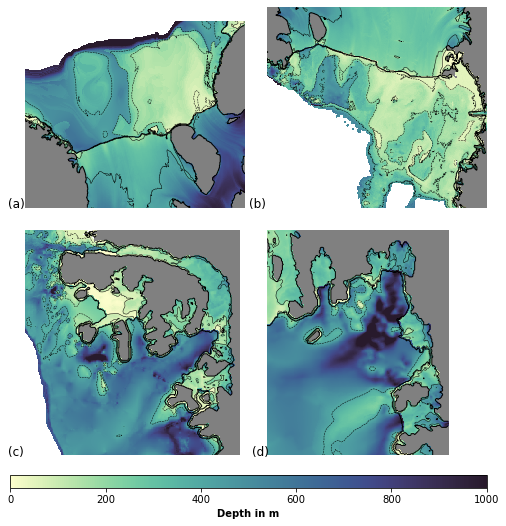

In [123]:
%matplotlib inline
fig = plt.figure(figsize=(8.27,9))

gs = gridspec.GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
img,ax1 = make_ax(ax1,sels['FRIS'],0,1000)

ax2 = fig.add_subplot(gs[0, 1])
img,ax2 = make_ax(ax2,sels['Ross'],0,1000)

ax3 = fig.add_subplot(gs[1, 0])
img,ax3 = make_ax(ax3,sels['GeorgeV'],0,1000)

ax4 = fig.add_subplot(gs[1, 1])
img,ax4 = make_ax(ax4,sels['PI'],0,1000)

plt.subplots_adjust(wspace=0.3,hspace=0.3)

for n,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.text(-0.08,0.0, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, size=12)
    
fig.subplots_adjust(bottom=0.15,wspace=0.1,hspace=0.1)
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

cbar = plt.colorbar(img, cax=cbar_ax, orientation="horizontal", pad=0.01)
cbar.set_label(label='Depth in m',weight='bold')
    
out_path = os.path.join(fig_dir,'zice_sstm_insets1.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")

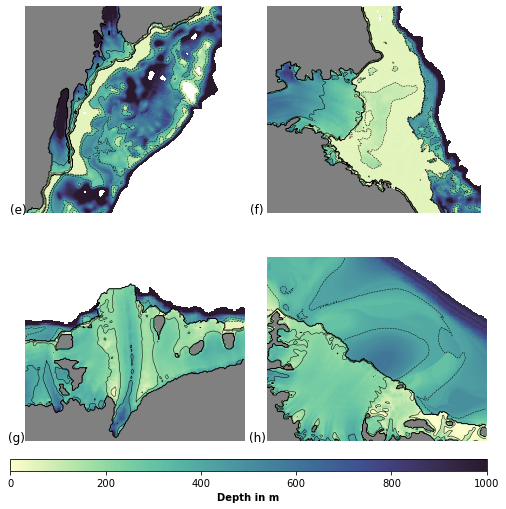

In [124]:
%matplotlib inline
fig = plt.figure(figsize=(8.27,8.27))

gs = gridspec.GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
img,ax1 = make_ax(ax1,sels['Totten'],0,1000)

ax2 = fig.add_subplot(gs[0, 1])
img,ax2 = make_ax(ax2,sels['Amery'],0,1000)

ax3 = fig.add_subplot(gs[1, 0])
img,ax3 = make_ax(ax3,sels['Fimbul'],0,1000)

ax4 = fig.add_subplot(gs[1, 1])
img,ax4 = make_ax(ax4,sels['LarsenC'],0,1000)

plt.subplots_adjust(wspace=0.3,hspace=0.3)

for n,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.text(-0.08,0.0, "("+string.ascii_lowercase[n+4]+")", transform=ax.transAxes, size=12)
    
fig.subplots_adjust(bottom=0.15,wspace=0.1,hspace=0.1)
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

cbar = plt.colorbar(img, cax=cbar_ax, orientation="horizontal", pad=0.01)
cbar.set_label(label='Depth in m',weight='bold')
    
out_path = os.path.join(fig_dir,'zice_sstm_insets2.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")

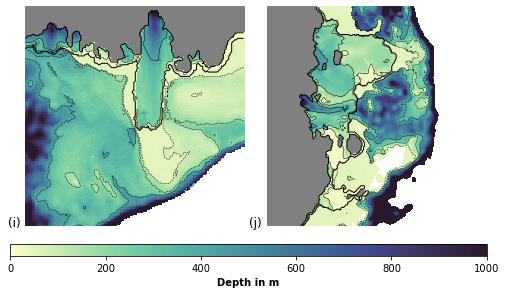

In [125]:
import matplotlib.gridspec as gridspec
import matplotlib
import string

%matplotlib inline
fig = plt.figure(figsize=(8.27,8.27))

gs = gridspec.GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
img,ax1 = make_ax(ax1,sels['Mertz'],0,1000)

ax2 = fig.add_subplot(gs[0, 1])
img,ax2 = make_ax(ax2,sels['Shackleton'],0,1000)

plt.subplots_adjust(wspace=0.3,hspace=0.3)

for n,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.text(-0.08,0.0, "("+string.ascii_lowercase[n+8]+")", transform=ax.transAxes, size=12)
    
fig.subplots_adjust(bottom=0.15,wspace=0.1,hspace=0.1)
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

cbar = plt.colorbar(img, cax=cbar_ax, orientation="horizontal", pad=0.01)
cbar.set_label(label='Depth in m',weight='bold')
   
out_path = os.path.join(fig_dir,'zice_sstm_insets3.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
plt.show()

# profiles

In [31]:
coords=[{'name':'Weddell Sea','eta':1900,'xi':1000},
        {'name':'Ross Sea','eta':610,'xi':1530},
        {'name':'Prydz Bay','eta':1640,'xi':2610},
        {'name':'Victoria land Coast','eta':290,'xi':2250}]

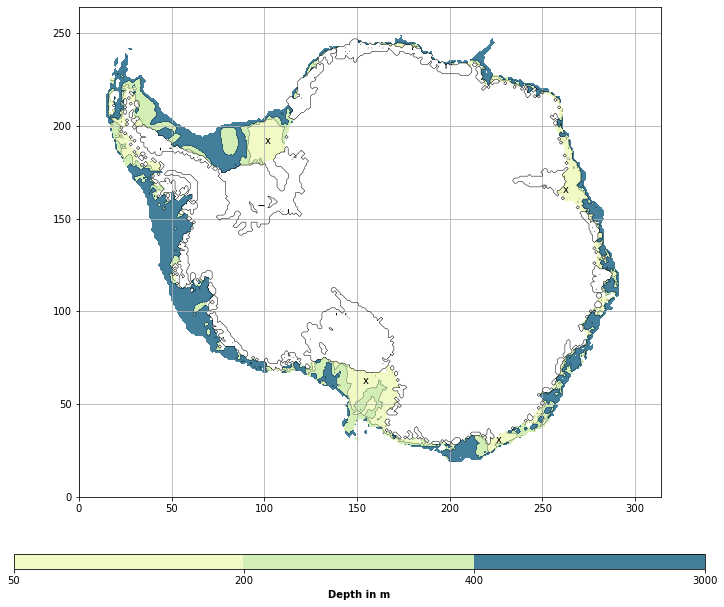

In [36]:
def make_ax(ax,sstm):
    #levs = [0,50,100,200,300,400,500,3000]
    levs = [50,200,400,3000]
    
    #cmap = matplotlib.colors.ListedColormap(['gray','white'])  
    #ax.pcolormesh(grd.mask_rho,cmap=cmap)
    
    img = ax.contourf(-sstm[::10,::10],levels=levs,cmap=ocm.deep)
    #ax.pcolormesh(-sstm,vmin=50,vmax=500,cmap=ocm.deep)
    ax.contour(-sstm[::10,::10],levels=levs,colors=('k'),linewidths=0.25,corner_mask=True)
    
    #z = grd.zice.where((grd.mask_rho ==1) & (grd.zice<0))
    #ax.contourf(-z,cmap=ocm.deep,levels=levs)
    #ax.contour(-z,levels=levs,colors='k',linewidths=0.25,corner_mask=True)
    
    
    ice_mask = (grd.zice < 0) & (grd.mask_rho ==1)
    ax.contour(ice_mask[::10,::10], levels=['0.1'], colors=('k'),linewidths=0.5)
    
    ax.set_aspect('equal')
    ax.grid()
    #ax.axis('off')
    #ax.set_ylim((176,2493))
    #ax.set_xlim((9,2919))
    
    return img,ax
    
plt.close()

fig,ax = plt.subplots(figsize=(12,10))

img,ax = make_ax(ax,sstm)

for loc in coords:

    ax.annotate('x',(loc['xi']/10,loc['eta']/10), xycoords='data')
#ax.annotate('x',(153, 61), xycoords='data')
#ax.annotate('x',(261, 164), xycoords='data')
#ax.annotate('x',(225,29), xycoords='data')

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

cbar = plt.colorbar(img, cax=cbar_ax, orientation="horizontal", pad=0.1)
cbar.set_label(label='Depth in m',weight='bold')
plt.show()

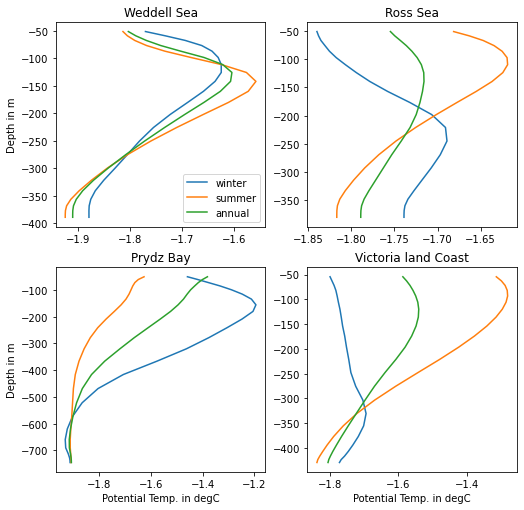

In [37]:
temp_wd = temp_w.where(temp_w.depth<-50)
temp_sd = temp_s.where(temp_s.depth<-50)
temp_d = temp.where(temp.depth<-50)

def make_ax(ax,eta,xi,name):
    temp_wd[:,eta,xi].plot(y='depth',label='winter',ax=ax)
    temp_sd[:,eta,xi].plot(y='depth',label='summer',ax=ax)
    temp_d[:,eta,xi].plot(y='depth',label='annual',ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel('')
    ax.set_title(name)
    return ax


fig,axes = plt.subplots(2,2,figsize=(8.27,8.27))
ax1,ax2,ax3,ax4 = axes.flatten()

for ax,loc in zip(axes.flatten(),coords): 
    ax = make_ax(ax,loc['eta'],loc['xi'],loc['name'])

ax1.legend()

ax1.set_ylabel('Depth in m')
ax3.set_ylabel('Depth in m')
ax3.set_xlabel('Potential Temp. in degC')
ax4.set_xlabel('Potential Temp. in degC')

#out_path = os.path.join(fig_dir,'Temp_profiles.png')
#fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")

plt.show()

# Zice

In [453]:
grd_path = os.path.join(data_dir,'interim','grd2_dV.nc')
grd = xr.open_dataset(grd_path)
grd.mask_rho[1000:1500,2000:2500] = False

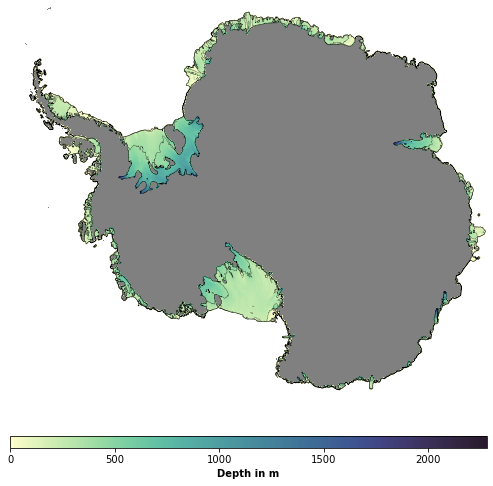

In [455]:
fig,ax = plt.subplots(figsize=(8.27,8.27))
levs = [200,400]

cmap = matplotlib.colors.ListedColormap(['gray','white'])  
ax.pcolormesh(grd.mask_rho,cmap=cmap)

z = grd.zice.where((grd.mask_rho ==1) & (grd.zice<0))
img = ax.pcolormesh(-z,cmap=ocm.deep)
ax.contour(-z,levels=levs,colors='k',linewidths=0.25,corner_mask=True)

ice_mask = (grd.zice < 0) & (grd.mask_rho ==1)
ax.contour(ice_mask, levels=['0.1'], colors=('k'),linewidths=0.5)


ax.set_aspect('equal')
ax.axis('off')
ax.set_xlim((40*5,576*5))
ax.set_ylim((50*5,500*5))

fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

cbar = plt.colorbar(img, cax=cbar_ax, orientation="horizontal", pad=0.01)
cbar.set_label(label='Depth in m',weight='bold')

out_path = os.path.join(fig_dir,'zice.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")

plt.show()

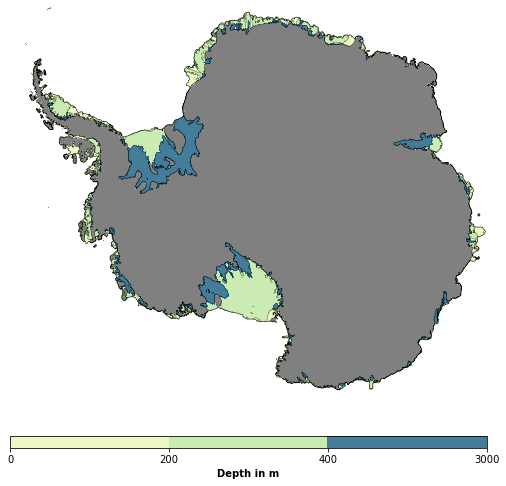

In [446]:
fig,ax = plt.subplots(figsize=(8.27,8.27))
levs = [0,200,400,3000]

cmap = matplotlib.colors.ListedColormap(['gray','white'])  
ax.pcolormesh(grd.mask_rho,cmap=cmap)

z = grd.zice.where((grd.mask_rho ==1) & (grd.zice<0))
img = ax.contourf(-z,cmap=ocm.deep,levels=levs)
ax.contour(-z,levels=levs,colors='k',linewidths=0.25,corner_mask=True)

ice_mask = (grd.zice < 0) & (grd.mask_rho ==1)
ax.contour(ice_mask, levels=['0.1'], colors=('k'),linewidths=0.5)

ax.set_aspect('equal')
ax.axis('off')
ax.set_xlim((40*5,576*5))
ax.set_ylim((50*5,500*5))

fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

cbar = plt.colorbar(img, cax=cbar_ax, orientation="horizontal", pad=0.01)
cbar.set_label(label='Depth in m',weight='bold')

out_path = os.path.join(fig_dir,'zice_depth_ranges.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")

plt.show()

# mixed layer depth

In [58]:
from unesco import unesco
grd_path = os.path.join(data_dir,'interim','grd2_dV.nc')
grd = xr.open_dataset(grd_path)

temp_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_temp_DJFavg.nc')
salt_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_salt_DJFavg.nc')
zeta_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_zeta_DJFavg.nc')

zeta_s = xr.open_dataset(zeta_path).zeta.squeeze()[::1,::1]
temp_s = xr.open_dataset(temp_path).temp.squeeze()[:,::1,::1]
salt_s = xr.open_dataset(salt_path).salt.squeeze()[:,::1,::1]

density = unesco(temp_s,salt_s,np.zeros_like(temp_s))

def assign_depth(ds,zeta):
    h = grd.h.values[::1,::1]
    zice = grd.zice.values[::1,::1]
    theta_s = 7
    theta_b = 8
    hc = 250
    N = 31
    zeta = zeta.values
    Vstretching = 4

    depths,s,C = calc_z(h,zice,theta_s,theta_b,hc,N,zeta,Vstretching)

    return ds.assign_coords(depth = xr.DataArray(depths,dims=['s_rho','eta_rho','xi_rho']))

temp_s = assign_depth(temp_s,zeta_s)

In [ ]:
density_anom = 0.03
mld = temp_s[0].copy()*0.0
depth = temp_s.depth*-1
mask = (grd.mask_rho==1) & (grd.zice==0)
mask = mask[::1,::1]
for j in log_progress(np.arange(mask.shape[0])):
        for i in np.arange(mask.shape[1]):
            # Check for land mask
            if mask[j,i]:
                density_sfc = density[-1,j,i]
                depth_sfc = np.zeros_like(depth[-1,j,i])#depth[-1,j,i]
                k = np.size(density,0)-2
                while True:
                    if k < 0:
                        mld[j,i] = depth[0,j,i]-depth_sfc
                        break
                    if density[k,j,i] >= density_sfc+density_anom:
                        mld[j,i] = depth[k,j,i]-depth_sfc
                        break
                    k-=1
mld = mld.where(mask)                

In [ ]:
out_path = os.path.join(int_dir,'mld_DJF_hr+.nc')
mld.to_netcdf(out_path)
#mld = xr.open_dataset(os.path.join(int_dir,'mld_DJF.nc')).temp

In [ ]:
mld_temp = temp_s.where(temp_s.depth>=-mld).mean('s_rho')

In [ ]:
mask = (grd.lat_rho<-60)
mask[:100,:]=False
mask[-101:]=False
mask[:,:100]=False
mask[:,-101:]=False

In [ ]:
import string
def make_ax(ax,vmin,vmax):
    ax.set_aspect('equal')
    ax.axis('off')


    cmap = matplotlib.colors.ListedColormap(['gray','white'])  
    ax.pcolormesh(grd.mask_rho[::1,::1],cmap=cmap) 
    cmap = matplotlib.colors.ListedColormap(['lightgray','white'])  
    ax.pcolormesh(grd.mask_rho.where((grd.mask_rho==1) & (grd.zice<0))[::1,::1],cmap=cmap)

    img = mld.where(mask[::1,::1]).plot(ax=ax,add_colorbar=False,vmin=vmin,vmax=vmax,cmap=ocm.deep)
    cb = plt.colorbar(img,ax=ax,orientation='horizontal',
                       label='Mixed layer depth in m',pad=0.01)
    ax.set_title('')
    ax.set_xlim((10,mld.shape[1]-10))
    ax.set_ylim((10,mld.shape[0]-10))
    
    return ax
    

import matplotlib
fig,axes = plt.subplots(ncols=2,figsize=(8.27,4.5))
ax1,ax2 = axes.flatten()

ax1 = make_ax(ax1,0,150)
ax2=make_ax(ax2,0,575)

for n,ax in enumerate(axes.flatten()):
    ax.text(-0.08,0.0, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, size=12)

fig.subplots_adjust(wspace=0.1,hspace=0.1)
plt.tight_layout()

out_path = os.path.join(fig_dir,'mld_DJF_hr.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(8.27,8.27))  
ax.set_aspect('equal')
ax.axis('off')


cmap = matplotlib.colors.ListedColormap(['gray','white'])  
ax.pcolormesh(grd.mask_rho[::1,::1],cmap=cmap) 
cmap = matplotlib.colors.ListedColormap(['lightgray','white'])  
ax.pcolormesh(grd.mask_rho.where((grd.mask_rho==1) & (grd.zice<0))[::1,::1],cmap=cmap)

img = mld_temp.where(mask[::1,::1]).plot(ax=ax,add_colorbar=False,vmin=-3,vmax=3,cmap=ocm.thermal)
cb = plt.colorbar(img,ax=ax,orientation='horizontal',
                   label='Mixed layer temperature in $^{\circ}$C',pad=0.01)
ax.set_title('')
ax.set_xlim((10,mld.shape[1]-10))
ax.set_ylim((10,mld.shape[0]-10))

fig.subplots_adjust(wspace=0.1,hspace=0.1)
plt.tight_layout()

out_path = os.path.join(fig_dir,'mld_temp_DJF_hr.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")

plt.show()